<a href="https://colab.research.google.com/github/HaeRin-OortCloud/AI-Lab/blob/main/ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [26]:
# Device Check
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)
      
BATCH_SIZE = 32
EPOCHS = 10

Using PyTorch version: 1.13.0+cu116  Device: cpu


In [27]:
# CIFAR10 Data Download
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10", 
                                 train = True, 
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomCrop(32, padding = 4),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()
                                 ]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.RandomCrop(32, padding = 4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor()
                                 ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

Files already downloaded and verified


In [28]:
# Data Cherck(1)
for (x_train, y_train) in train_loader:
  print('x_train:', x_train.size(), 'type:', x_train.type())
  print('y_train:', y_train.size(), 'type:', y_train.type())
  break

x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


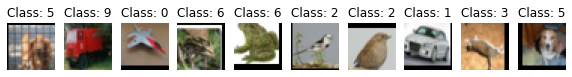

In [29]:
# Data Check(2)
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis('off')
  plt.imshow(np.transpose(x_train[i], (1, 2, 0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [30]:
# ResNet Model Design

## Basic Block 정의
class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
          nn.BatchNorm2d(planes)
          )
  
  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


## ResNet 정의
class ResNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_planes = 16

    self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16, 2, stride = 1)
    self.layer2 = self._make_layer(32, 2, stride = 2)
    self.layer3 = self._make_layer(64, 2, stride = 2)
    self.linear = nn.Linear(64, num_classes)
  
  def _make_layer(self, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(BasicBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 8)
    out = out.view(out.size(0), -1)
    out = self.linear(out) 
    return out

In [31]:
# Objective Function, Optimizer, Learning Rate
model = ResNet().to(DEVICE)
learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9) #weight_decay = 0.0002

def adjust_learning_rate(optimizer, Epoch):
  lr = learning_rate
  if Epoch >= 100:
    lr /= 10
  if Epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [37]:
# def Train
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".
            format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item())) 

In [38]:
# def Evaluate
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [40]:
# Final
for Epoch in range(1, EPOCHS + 1):
  adjust_learning_rate(optimizer, Epoch)
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".
        format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 1.220834
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 0.979014
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 0.863927
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 0.931146
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 0.978732
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.009676
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 0.757354
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.322927

[EPOCH: 1], 	Test Loss: 0.0318, 	Test Accuracy: 65.78 % 

Train Epoch: 2 [0/50000(0%)]	Train Loss: 0.751214
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.126985
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 0.996427
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 0.892859
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 0.692556
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 0.552600
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 0.871385
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 0.487218

[EPOCH: 2], 	Test Loss: 0.0294, 	Test Accuracy: 67.25 % 

Train Epoch: 3